In [1]:
%load_ext autoreload
%autoreload 2
%debug

import os, glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib as mpl
mpl.rc('image', cmap='inferno')

import models.model_2d as mod
import forward_model_tf as fm
import utils as ut

# for resizing PSFs as appropriate:
import cv2

import load_PSFs

ERROR:root:No traceback has been produced, nothing to debug.


In [2]:
!gpustat

/bin/bash: /home/dshteinbok/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: gpustat: command not found


In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

os.environ["CUDA_VISIBLE_DEVICES"]="1" 

# Training code for 2D spatially-varying deconvolutions

In [4]:
# one setting to rule them all
# preset = 'single_depth_probe'
preset = 'single_depth_probe_noisy'
# preset = 'multiple_depths_probe'

In [5]:
# declare all the variables that control how the model is set up and trained.
# Point to the training data:
# target_dir = '/home/dshteinbok/TrainingData/Ground_truth_downsampled/'  # path to objects (ground truth)
# input_dir = '/home/dshteinbok/TrainingData/Simulated_Miniscope_2D_Training_data/'    # path to simulated measurements (inputs to deconv.)

target_dir = '../data/nV3_resized/'  # path to objects (ground truth)
# input_dir = '../data/nV3_simulated/'    # path to simulated measurements (inputs to deconv.)
# input_dir = '../data/nV3_mastermat_bare/'    # path to simulated measurements (inputs to deconv.)
input_dir = '../data/nV3_mastermat_probe_unshifted/'    # path to simulated measurements (inputs to deconv.)
# input_dir = '../data/nV3_mastermat_probe_unshifted_noisy/'
# input_dirs = ['../data/nV3_mastermat_probe_unshifted/']  
# input_dirs = ['../data/nV3_mastermat_probe_unshifted_depth1/',
#              '../data/nV3_mastermat_probe_unshifted_depth2/',
#              '../data/nV3_mastermat_probe_unshifted_depth3/']

# target_dir = '/home/dshteinbok/TrainingData/Ground_truth_downsampled/'
# input_dir = '/home/dshteinbok/TrainingData/Simulated_Miniscope_2D_Training_data/'

# PSF load type: could be "matlab"
# psf_loadtype = "matlab"
psf_loadtype = "csv"

# PSF locations, if psf_loadtype=="matlab"
filter_init_path = '../data/multiWienerPSFStack_40z_aligned.mat' # initialize with 9 PSFs
filter_key = 'multiWienerPSFStack_40z'  # key to load in

# multiple_psfs = False
multiple_psfs = True

# PSF directory, if psf_loadtype=="csv"
# psfs_path = '/home/dshteinbok/nV3_PSFs'
# psfs_path = "/home/dshteinbok/nV3_PSFs_flat_hd"
psfs_path = "/home/dshteinbok/nV3_PSFs_probe_mark_green"
psfs_paths = ["/home/dshteinbok/nV3_PSFs_probe_mark_green"]
# psfs_paths = ["/home/dshteinbok/nV3_PSFs_probe_depth1/", "/home/dshteinbok/nV3_PSFs_probe_depth2/", "/home/dshteinbok/nV3_PSFs_probe_depth3/"]
# meta_path = '/home/dshteinbok/nV3_PSFs_meta/PSF_Shifts.csv'
# meta_path = "/home/dshteinbok/nV3_PSFs_flat_meta/metafile_hd.csv"
meta_path = "/home/dshteinbok/nV3_PSFs_meta/metafile_probe_mark.csv"
meta_paths = ["/home/dshteinbok/nV3_PSFs_probe_depths/metafile_probe_depth1.csv", \
              "/home/dshteinbok/nV3_PSFs_probe_depths/metafile_probe_depth2.csv",
             "/home/dshteinbok/nV3_PSFs_probe_depths/metafile_probe_depth3.csv"]

# Pixel size of the images we're dealing with. This must be the same as the desired PSF size. 
# Program will adjust size of PSFs by linear interpolation as needed, but will only crop images.
# img_dims is (width, height)
img_dims = (1280, 800)
# img_dims = (648, 486)

# choose network type to train
model_type='multiwiener' # choices are 'multiwiener', 'wiener', 'unet'

# IMPORTANT! CHANGE WHEN NEEDED!
# where to store weights and training info
# training_location = "saved_models/multiwiener_nV3_bare/model_weights"
# epochlog_location = "saved_models/multiwiener_nV3_bare/epoch.log"
# training_location = "saved_models/multiwiener_nV3_probe/model_weights"
training_location = "saved_models/multiwiener_nV3_probe_depths/model_weights"
# epochlog_location = "saved_models/multiwiener_nV3_probe/epoch.log"
epochlog_location = "saved_models/multiwiener_nV3_probe_depths/epoch.log"
# training_location = "saved_models/waller/model_weights"
# epochlog_location = "saved_models/waller/epoch.log"

In [6]:
if preset == 'single_depth_probe':
    multiple_psfs = False
    target_dir = '../data/nV3_resized/'  # path to objects (ground truth)
#     input_dir = '../data/nV3_mastermat_probe_unshifted/'    # path to simulated measurements (inputs to deconv.)
    psfs_path = "/home/dshteinbok/nV3_PSFs_probe_mark_green"
    training_location = "saved_models/multiwiener_nV3_probe/model_weights"
    epochlog_location = "saved_models/multiwiener_nV3_probe/epoch.log"
if preset == 'single_depth_probe_noisy':
    multiple_psfs = False
    target_dir = '../data/nV3_resized/'  # path to objects (ground truth)
#     input_dir = '../data/nV3_mastermat_probe_unshifted/'    # path to simulated measurements (inputs to deconv.)
    input_dir = '../data/nV3_mastermat_probe_unshifted_noisy/'
#     input_dir = '../data/nV3_mastermat_probe_unshifted/' # temporary, since we are adding noise on training
    psfs_path = "/home/dshteinbok/nV3_PSFs_probe_mark_green"
    training_location = "saved_models/multiwiener_nV3_probe_noisy2/model_weights"
    epochlog_location = "saved_models/multiwiener_nV3_probe_noisy2/epoch.log"
elif preset == 'multiple_depths_probe':
    multiple_psfs = True
    target_dir = '../data/nV3_resized/'  # path to objects (ground truth)
    input_dirs = ['../data/nV3_mastermat_probe_unshifted_depth1/',
             '../data/nV3_mastermat_probe_unshifted_depth2/',
             '../data/nV3_mastermat_probe_unshifted_depth3/']
    psfs_paths = ["/home/dshteinbok/nV3_PSFs_probe_depth1/", 
                  "/home/dshteinbok/nV3_PSFs_probe_depth2/", 
                  "/home/dshteinbok/nV3_PSFs_probe_depth3/"]
    training_location = "saved_models/multiwiener_nV3_probe_depths/model_weights"
    epochlog_location = "saved_models/multiwiener_nV3_probe_depths/epoch.log"

In [7]:
# multiple_psfs = True

In [8]:
input_dirs = [input_dir]

## Make dataset and dataloader for training data

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 1

In [10]:

if multiple_psfs:
    target_path = (sorted(glob.glob(target_dir + '*')))*len(input_dirs)
    input_path_lists = [(sorted(glob.glob(input_dir + '*'))) for input_dir in input_dirs]
    input_path = []
    for pathset in input_path_lists:
        for path in pathset:
            input_path.append(path)
else:
    input_path = sorted(glob.glob(input_dir + '*'))
    target_path = sorted(glob.glob(target_dir + '*'))

image_count=len(os.listdir(target_dir))
print(image_count) 

22126


In [11]:
len(input_path)

22126

In [12]:
len(target_path)

22126

In [13]:
target_path[-1]

'../data/nV3_resized/9999.png'

In [14]:
# input_path_lists[1]

In [15]:
# input_path[-1]

In [16]:
# Create a first dataset of file paths and labels
dataset = tf.data.Dataset.from_tensor_slices((input_path, target_path))
dataset = dataset.shuffle(image_count, seed=0, reshuffle_each_iteration=False)


# Split into train/validation
val_size = int(image_count * 0.25)

# took a small number of samples for test training to make epochs go faster
train_ds = dataset.skip(val_size)
#train_ds = dataset.skip(val_size).take(100)
#train_ds = dataset.take(100)

val_ds = dataset.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

train_ds = train_ds.map(ut.parse_function, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(ut.parse_function, num_parallel_calls=AUTOTUNE)

train_ds = ut.configure_for_performance(train_ds,batch_size)
val_ds = ut.configure_for_performance(val_ds,batch_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

16595
5531
16595
5531


In [17]:
# for x, y in train_ds:
#     print("x has shape: ", x.shape)
#     print("y has shape: ", y.shape)

/tmp/ipykernel_688256/1429360126.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread('../data/nV3_mastermat_bare/1079.png'))


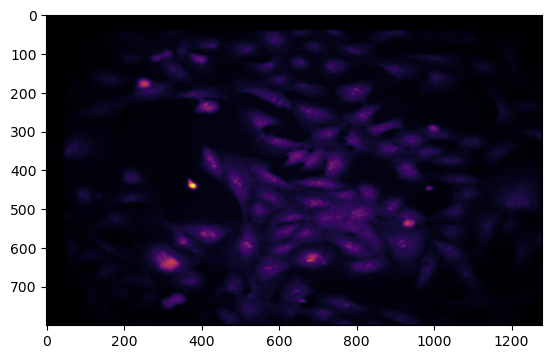

In [18]:
import imageio
plt.imshow(imageio.imread('../data/nV3_mastermat_bare/1079.png'))

In [19]:
train_ds.get_single_element?

(800, 1280)


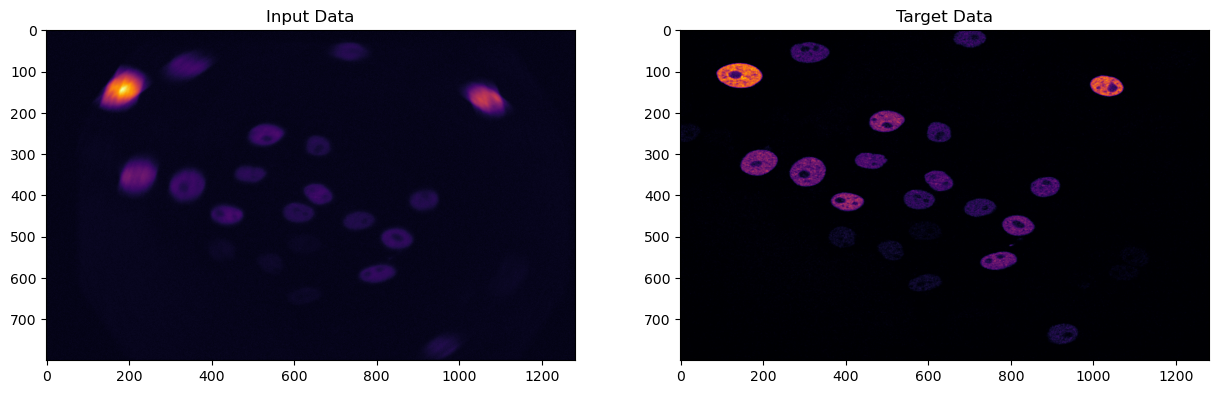

In [20]:
#visualzie data to make sure all is good
# import pdb
# pdb.set_trace()
input_batch, target_batch = next(iter(val_ds))
f, ax = plt.subplots(1, 2, figsize=(15,15))

ax[0].imshow(input_batch[0,:,:,0], vmax = 1)
ax[0].set_title('Input Data')

ax[1].imshow(target_batch[0,:,:,0], vmax = 1)
ax[1].set_title('Target Data')

print(input_batch[0,:,:,0].shape)

In [21]:
# for path in input_path:
#     try:
#         print(path)
#         imageio.imread(path)
#     except:
#         print("BROKEN: " + path)

In [22]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

# load in Psfs and initialize network to train

Here we initialize with 9 PSFs taken from different parts in the field of view

In [23]:
import sys
sys.path.append("../common")
import csv_psfs
from IPython.core.debugger import set_trace

# load the PSFs
if psf_loadtype == "matlab":
    registered_psfs_path = filter_init_path
    psfs = scipy.io.loadmat(registered_psfs_path)
    psfs=psfs[filter_key]
elif psf_loadtype == "csv":
#     # expect a directory with a bunch of PSFs therein as separate csvs;
#     # list out all csv file names in the directory
#     psf_paths = glob.glob(psfs_path.removesuffix('/') + '/*')
#     # iterate through that list,
#     # open and append each to the psfs array,
#     psfs = [[]]
#     for path in psf_paths:
#         #psfs[0].append(np.loadtxt(path, delimiter=',', encoding='utf-8-sig'))
#         psfs[0].append(np.loadtxt(path, delimiter=','))
#     # convert the psfs array to an np.ndarray
#     psfs = np.transpose(np.asarray(psfs), (2,3,1,0))
    set_trace()
##     psfs = load_PSFs.load_PSFs_csv(psfs_path, meta_path, img_dims)[:,:,:,0]
#     if not multiple_psfs: 
#         psfs = csv_psfs.pad_as_center(csv_psfs.load_from_dir(psfs_path), img_dims[1], img_dims[0])

# handle multiple sets of PSFs:
    # FIXME: magic number 63 is 3*the number of PSFs per metafile
    if multiple_psfs:
        psfs = np.empty((img_dims[1], img_dims[0], 21*3))
        for i in range(len(psfs_paths)):
            psfs[:,:,i:i+21] = csv_psfs.pad_as_center(csv_psfs.load_from_dir(psfs_paths[i]), img_dims[1], img_dims[0])
    else:
        psfs = csv_psfs.pad_as_center(csv_psfs.load_from_dir(psfs_path), img_dims[1], img_dims[0])
else:
    raise ValueError("Not sure how to load PSFs")
psfs.shape

# for testing, cut the psf and look at padding behaviour
#psfs = psfs[162:324, 216:432, :, :]
#psfs.shape
# Test result: it works!!!

> /tmp/ipykernel_688256/3845168668.py(30)<cell line: 7>()
     28 # handle multiple sets of PSFs:
     29     # FIXME: magic number 63 is 3*the number of PSFs per metafile
---> 30     if multiple_psfs:
     31         psfs = np.empty((img_dims[1], img_dims[0], 21*3))
     32         for i in range(len(psfs_paths)):

ipdb> n
> /tmp/ipykernel_688256/3845168668.py(35)<cell line: 7>()
     33             psfs[:,:,i:i+21] = csv_psfs.pad_as_center(csv_psfs.load_from_dir(psfs_paths[i]), img_dims[1], img_dims[0])
     34     else:
---> 35         psfs = csv_psfs.pad_as_center(csv_psfs.load_from_dir(psfs_path), img_dims[1], img_dims[0])
     36 else:
     37     raise ValueError("Not sure how to load PSFs")

ipdb> c


(800, 1280, 21)

In [24]:
# type(psfs_paths) == list

In [25]:
type("string") == str

True

In [26]:
psfs.shape

(800, 1280, 21)

In [ ]:
set_trace()

if model_type=='unet':
    model =mod.UNet(486, 648, 
                             encoding_cs=[24, 64, 128, 256, 512, 1024],
                             center_cs=1024,
                             decoding_cs=[512, 256, 128, 64, 24, 24],
                             skip_connections=[True, True, True, True, True, False])
elif model_type=='wiener':

    registered_psfs_path = filter_init_path
    psfs = scipy.io.loadmat(registered_psfs_path)
    psfs=psfs[filter_key]
    psfs=psfs[:,:,0,0]
    psfs=psfs/np.max(psfs)
    
    Ks=1

    model = mod.UNet_wiener(486, 648, psfs, Ks, 
                             encoding_cs=[24, 64, 128, 256, 512, 1024],
                             center_cs=1024,
                             decoding_cs=[512, 256, 128, 64, 24, 24],
                             skip_connections=[True, True, True, True, True, False])
    
    print(psfs.shape, 1)
    
elif model_type=='multiwiener':
    # assume psfs is already 3-dimensional if our PSFs are used
    # if matlab-style is used, it's typically an academic who likes 4D
    if psf_loadtype == "matlab":
        psfs=psfs[:,:,:,0]
    print(psfs.shape)
    #psfs = cv2.resize(psfs, img_dims)
    # rather than resizing, zero-pad to appropriate size
    # this means that original PSF can be any size, but Image Delta must be set correctly
    
    print(psfs.shape)
    psfs=psfs/np.max(psfs)
    if multiple_psfs:
        psfs_keep = psfs[:,:,list(range(0,11))+list(range(21,32))+list(range(43,54))]*1
#         psfs_keep = psfs*1
    #     psfs_keep = psfs[:,:,list(range(0,11))+list(range(21,32))]*1
    #     psfs_keep = psfs[:,:,0:21]*1
        print(psfs_keep.shape)

    #     Ks =np.ones((1,1,psfs.shape[2]))
        Ks_keep = np.ones((1,1,psfs_keep.shape[2]))
        print(Ks_keep.shape)

        model =mod.UNet_multiwiener_resize(img_dims[1], img_dims[0], psfs_keep, Ks_keep, 
                             encoding_cs=[24, 64, 128, 256, 512, 1024],
                             center_cs=1024,
                             decoding_cs=[512, 256, 128, 64, 24, 24],
                             skip_connections=[True, True, True, True, True, False], psfs_trainable=True)
#     model =mod.UNet_multiwiener_resize(img_dims[1], img_dims[0], psfs, Ks, 
#                          encoding_cs=[24, 64, 128, 256, 512, 1024],
#                          center_cs=1024,
#                          decoding_cs=[512, 256, 128, 64, 24, 24],
#                          skip_connections=[True, True, True, True, True, False])

# made PSFs untrainable
    else:
        Ks =np.ones((1,1,psfs.shape[2]))
        model =mod.UNet_multiwiener_resize(img_dims[1], img_dims[0], psfs, Ks, 
                             encoding_cs=[24, 64, 128, 256, 512, 1024],
                             center_cs=1024,
                             decoding_cs=[512, 256, 128, 64, 24, 24],
                             skip_connections=[True, True, True, True, True, False], psfs_trainable=True,
                                training_noise=True)
#     model =mod.UNet_multiwiener_resize(img_dims[1], img_dims[0], psfs_keep, Ks_keep, 
#                          encoding_cs=[24, 64, 128, 256, 512, 1024],
#                          center_cs=1024,
#                          decoding_cs=[512, 256, 128, 64, 24, 24],
#                          skip_connections=[True, True, True, True, True, False], psfs_trainable=True)
    
#     print('initialized filter shape:', psfs.shape, 'initialized K shape:', Ks.shape)
# print('initialized filter shape:', psfs_keep.shape, 'initialized K shape:', Ks_keep.shape)

--Return--
None
> /tmp/ipykernel_688256/4157262434.py(1)<cell line: 1>()
----> 1 set_trace()
      2 
      3 if model_type=='unet':
      4     model =mod.UNet(486, 648, 
      5                              encoding_cs=[24, 64, 128, 256, 512, 1024],

ipdb> ll
----> 1 set_trace()
      2 
      3 if model_type=='unet':
      4     model =mod.UNet(486, 648, 
      5                              encoding_cs=[24, 64, 128, 256, 512, 1024],
      6                              center_cs=1024,
      7                              decoding_cs=[512, 256, 128, 64, 24, 24],
      8                              skip_connections=[True, True, True, True, True, False])
      9 elif model_type=='wiener':
     10 
     11     registered_psfs_path = filter_init_path
     12     psfs = scipy.io.loadmat(registered_psfs_path)
     13     psfs=psfs[filter_key]
     14     psfs=psfs[:,:,0,0]
     15     psfs=psfs/np.max(psfs)
     16 
     17     Ks=1
     18 
     19     model = mod.UNet_wiener(486, 648, 

ipdb> b 64
Breakpoint 1 at /tmp/ipykernel_688256/4157262434.py:64
ipdb> c
    [... skipped 1 hidden frame]

    [... skipped 1 hidden frame]

    [... skipped 1 hidden frame]

    [... skipped 1 hidden frame]

(800, 1280, 21)
(800, 1280, 21)
None
> /tmp/ipykernel_688256/4157262434.py(64)<cell line: 3>()
     62     else:
     63         Ks =np.ones((1,1,psfs.shape[2]))
1--> 64         model =mod.UNet_multiwiener_resize(img_dims[1], img_dims[0], psfs, Ks, 
     65                              encoding_cs=[24, 64, 128, 256, 512, 1024],
     66                              center_cs=1024,

ipdb> type(psfs)
<class 'numpy.ndarray'>
ipdb> psfs.shape
(800, 1280, 21)


In [ ]:
list(range(10))

In [ ]:
psfs.shape

In [ ]:
model.build((None, img_dims[1], img_dims[0], 1))

model.summary()

In [ ]:
#tf.config.list_physical_devices()

In [ ]:
# np.any(np.isnan(psfs_keep))

# Train

In [ ]:
# ADDED BY DANIEL:
# Prepare EpochLogger and load weights, if necessary, into the model
# %debug
# set_trace()
import epochlog.epochlog as el
epochlogger = el.EpochLogger(model, epochlog_location, training_location)
epochlogger.load_weights()
print("done all the crap")

## Training with TF.Dataset
initial_learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False) #1e-3 diverges

# what's the expected input shape for the model?
exp_shape = model.get_config()["layers"][0]["config"]["batch_input_shape"]
print(exp_shape)

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []
validtate_loss_results=[]
num_epochs = 100
loss_func=ut.SSIMLoss_l1
learning_rate_counter=0
#for epoch in range(num_epochs):
starting_epoch = epochlogger.epochs_done()
print("Starting on epoch number: " + str(starting_epoch))
for epoch in range(starting_epoch, num_epochs):
    validation_loss_avg=tf.keras.metrics.Mean()
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.MeanSquaredError()

    # Training loop
    iter_num=0
    for x, y in train_ds:
        # Optimize the model
        #print("x shape: " + str(x.shape))
        #print("y shape: " + str(y.shape))
        # NOTICE: x.shape = y.shape = (2, 486, 648, 1)
        # TODO: resize x and y based on expected dimensions for the model
        # Crop to the top left corner of the image to make it fit our size if it is too large
        if x.shape[1] > exp_shape[1]:
            x = x[:,:exp_shape[1],:,:]
        if x.shape[2] > exp_shape[2]:
            x = x[:,:,:exp_shape[2],:]
        if y.shape[1] > exp_shape[1]:
            y = y[:,:exp_shape[1],:,:]
        if y.shape[2] > exp_shape[2]:
            y = y[:,:,:exp_shape[2],:]
        loss_value, grads = ut.grad(model,loss_func, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss

        epoch_accuracy.update_state(y, model(x)) 
        # Print every 1
        if iter_num % 1 == 0:
            print("Epoch {:03d}: Step: {:03d}, Loss: {:.3f}, MSE: {:.3}".format(epoch, iter_num,epoch_loss_avg.result(),
                                                                        epoch_accuracy.result()),end='\r')
        iter_num=iter_num+1
        
    

  # End epoch
    #print("Ending Epoch")
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())


    # skip validation, since SSIM function is broken
    #for x_val, y_val in val_ds:
        #val_loss_value= loss_func(model, x_val, y_val)
        #validation_loss_avg.update_state(val_loss_value)
        
        
    validtate_loss_results.append(validation_loss_avg.result())    
    #if epoch % 1 == 0:
        #print("Epoch {:03d}: MSE: {:.3}, Training Loss: {:.3f}, Validation Loss: {:.3f}".format(epoch,
        #                                                            epoch_accuracy.result(), epoch_loss_avg.result(), 
        #                                                                                        validation_loss_avg.result()))
    epochlogger.done_epoch()

In [ ]:
epochlogger = el.EpochLogger(model, epochlog_location, training_location)
epochlogger.load_weights()

In [ ]:
# model.load_weights('./saved_models/multiwiener')

In [ ]:
plt.imshow(imageio.imread("/home/dshteinbok/noisy_real_images/10.png"))

In [ ]:
input_batch, target_batch = next(iter(val_ds))
input_batch.shape

In [ ]:
# test on validation data
input_batch, target_batch = next(iter(val_ds))
imnum=0
f, ax = plt.subplots(3, 1, figsize=(15,15))
# ax[0].imshow((target_batch[imnum,:,:,0]))
ax[0].imshow((target_batch[imnum,:,:]))
ax[0].set_title('Target Data')

# test=model(input_batch[imnum,:,:,0].numpy().reshape((1,486, 648,1)))
test=model(input_batch[imnum,:,:].numpy().reshape((1,img_dims[1], img_dims[0],1)))
ax[2].set_title('recon')
ax[2].imshow(test[0,:,:])

ax[1].imshow((input_batch[imnum,:,:]))
ax[1].set_title('Input Data')

In [ ]:
np.all(np.isnan(test[0,:,:]))

In [ ]:
to_reconstruct_index = 9
# folderpath = "/home/dshteinbok/real_images/"
# to_reconstruct = imageio.imread(folderpath+"image_"+str(to_reconstruct_index)+".png")
# img_path_to_do = "/home/dshteinbok/denoised_real_images/30.png"
img_path_to_do = "/home/dshteinbok/noisy_real_images/40.png"
to_reconstruct = cv2.resize(imageio.imread(img_path_to_do), (1280, 800))

fig, axs = plt.subplots(1,2, figsize=(15,15))
axs[0].imshow(to_reconstruct)
axs[1].imshow(model(to_reconstruct.reshape((1,800,1280,1)))[0,:,:])

In [ ]:
plt.figure(figsize=(80,128))
plt.imshow(model(to_reconstruct.reshape((1,800,1280,1)))[0,:,:])

In [ ]:
plt.imshow(imageio.imread("/home/dshteinbok/real_images_unpadded/isxd_9.png"))

Once training is working, save your model using: 

    model.save_weights('./saved_models/model_name')

You can save after training is complete, or periodically throughout epochs.

In [ ]:
# show the first PSF as an example of what we're looking for
plt.imshow(psfs[:,:,0])